# Library and import

In [1]:
!pip install pulp
!pip install SciPy

  Using cached PuLP-2.8.0-py3-none-any.whl (17.7 MB)


In [2]:
#Linear optimization library
from pulp import *

#Non-linear optimization library
from scipy.optimize import minimize
import scipy

#Data manippulation library
import pandas as pd
import numpy as np

#Visulization library
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plot

# Common parameters

In [3]:
#Given parameters
simulations = 10000 #number of simulations
Lambda = 357.46
Beta = 82.38
Epsilon = {"mu":[0], 
          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
X = {"mu":[0],
    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
retail_price = 3
wholesale_price = 1

#Randomized Epsilon and X
Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation

Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2))

# Non-linear profit optimization

## Part A, traditional forecasting

### Optimize by finding Optimal stock

In [4]:
#Given parameters
#simulations = 10000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation))

#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2))
#print(sum(Actual_demand)/len(Actual_demand))

# Define the objective function
def objective_function(params, Actual_demand, retail_price, wholesale_price):
    #Stock = params
    Stocks = np.array([params]*simulations).squeeze()
    #assert Stocks.shape == (100,), f"stock shape is not 100, but {Stocks.shape}"
 
    # Calculate profit
    revenue = np.minimum(Actual_demand, Stocks) * retail_price
            
    cost = Stocks * wholesale_price
    profit = revenue - cost 
    #assert profit.shape[0] == simulations, profit.shape()
    return -profit.mean()  # Minimize the negative of the average profit to maximize the average profit

# Perform minimization
optimal_result = scipy.optimize.minimize(objective_function, x0=0, args=(Actual_demand, retail_price, wholesale_price), bounds=[(-500, 500)])

# Extract optimal X and Epsilon from the result
optimal_stock_1_NLP = optimal_result.x[0]

Stock_1_NLP = [optimal_stock_1_NLP]*simulations #Variable for graphing
#print(Stock_1_NLP[0:10])
#print(len(Stock_1_NLP))

# Calculate the average profit for the optimal solution
average_profit_1_NLP = -optimal_result.fun

# Print the results
print("Optimal profit: " + "€" + str(np.round(average_profit_1_NLP,2)))
print("Optimal stock: " + str(np.round(optimal_stock_1_NLP,2)) + " kg")

#Finding waste
waste_1_NLP = []
for i in range(simulations):
    if Actual_demand[i] < optimal_stock_1_NLP:
        waste_1_NLP.append(optimal_stock_1_NLP - Actual_demand[i])
#    else:
#        waste_1.append(0)

average_waste_1_NLP = np.round(np.array(waste_1_NLP).mean())

print("Average stock waste: " + str(average_waste_1_NLP) + " kg")

Optimal profit: €636.44
Optimal stock: 387.54 kg
Average stock waste: 69.0 kg


### Optimize by finding optimal X and Epsilon

In [5]:
#Given parameters
#simulations = 10000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation))

#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2))
#print(sum(Actual_demand)/len(Actual_demand))

# Define the objective function
waste_instances_1 = []
def objective_function(params, Lambda, Beta, Actual_demand, retail_price, wholesale_price):
    X, Epsilon = params
    Xs = np.array([X]*simulations).squeeze()
    Epsilons = np.array([Epsilon]*simulations).squeeze()
    # Calculate predicted demand
    Stocks = Lambda + Beta * Xs + Epsilons
    
    #Calculate waste 
    global waste_instances_1
    waste_instances_1 = []
    for i in range(simulations):
        if Actual_demand[i] < Stocks[i]:
            waste_instances_1.append(Stocks[i]-Actual_demand[i])
    
    # Calculate profit
    revenue = np.minimum(Actual_demand, Stocks) * retail_price
    cost = Stocks * wholesale_price
    profit = revenue - cost
    
    return -profit.mean()  # Minimize the negative of the average profit to maximize the average profit

# Generate initial guess for X and Epsilon
initial_guess = np.array([0, 0])

# Perform minimization
optimal_result = scipy.optimize.minimize(objective_function, x0=initial_guess, args=(Lambda, Beta, Actual_demand, retail_price, wholesale_price), bounds=[(-500, 500), (-500, 500)])

# Extract optimal X and Epsilon from the result
optimal_X = optimal_result.x[0]
optimal_Epsilon = optimal_result.x[1]

#Calculate optimal Stock through X and Epsilon
Stock = Lambda + Beta * optimal_X + optimal_Epsilon

Stock_2_NLP = [Stock]*simulations #Variable for graphing
#print(Stock_2_NLP[0:10])
#print(len(Stock_2_NLP))

# Calculate the average profit for the optimal solution
average_profit_2_NLP = -optimal_result.fun

# Print the results
print("Optimal profit: " + "€" + str(np.round(average_profit_2_NLP,2)))
print("Optimal X:", optimal_X)
print("Optimal Epsilon:", optimal_Epsilon)

# Print the optimal stock value
print("Stock: " + str(np.round(Stock,2)) + " kg")

#Finding waste
waste_2_NLP = []
for i in range(simulations):
    if Actual_demand[i] < Stock:
        waste_2_NLP.append(Stock- Actual_demand[i])
#    else:
#        waste_2.append(0)

average_waste_2_NLP = np.round(np.array(waste_2_NLP).mean())

print("Average stock waste: " + str(average_waste_2_NLP) + " kg")

Optimal profit: €636.44
Optimal X: 0.36502625633335534
Optimal Epsilon: 0.004431115560177362
Stock: 387.54 kg
Average stock waste: 69.0 kg


## Part B with Blockchain

### Optimize by finding optimal Epsilon (Residual)

In [6]:
#Given parameters
#simulations = 10000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation))

#Actual demand from randomized Epsilon and X
#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] 
#print(np.round(Actual_demand,2))
#print(sum(Actual_demand)/len(Actual_demand))

# Define the objective function
def objective_function(params, Lambda, Beta, X, Actual_demand, retail_price, wholesale_price):
    Epsilon = params
    Epsilons = np.array([Epsilon]*simulations).squeeze()
   
    # Calculate predicted demand
    Stocks = Lambda + Beta * X + Epsilons   
    
    # Calculate profit
    revenue = np.minimum(Actual_demand, Stocks) * retail_price
    cost = Stocks * wholesale_price
    profit = revenue - cost
    
    return -profit.mean()  # Minimize the negative of the average profit to maximize the average profit

# Generate initial guess for X and Epsilon
initial_guess = np.array([0])

# Perform minimization
optimal_result = scipy.optimize.minimize(objective_function, x0=initial_guess, args=(Lambda, Beta, X_simulation, Actual_demand, retail_price, wholesale_price), bounds=[(-500, 500)])

# Extract optimal Epsilon from the result
optimal_Epsilon = optimal_result.x[0]

# Calculate the average profit for the optimal solution
average_profit_3_NLP = -optimal_result.fun

# Print the results
print("Optimal profit: " + "€" + str(np.round(average_profit_3_NLP,2)))
print("Optimal Epsilon:", optimal_Epsilon)

#Stock of each simualation calculated
Stock_cal = []
for i in range(simulations):
    Stock_cal.append(Lambda + Beta * X_simulation[i] + optimal_Epsilon)

Stock_3_NLP = Stock_cal #Variable for graphing
#print(Stock_3_NLP[0:10])
#print(len(Stock_3_NLP))
    
#Finding waste
waste_3_NLP = []
for i in range(simulations):
    if Actual_demand[i] < Stock_cal[i]:
        waste_3_NLP.append(Stock_cal[i]- Actual_demand[i])
#    else:
#        waste_3.append(0)

average_waste_3_NLP = np.round(np.array(waste_3_NLP).mean())

print("Average stock waste: " + str(average_waste_3_NLP) + " kg")

Optimal profit: €664.16
Optimal Epsilon: 18.7088093994274
Average stock waste: 44.0 kg


# Changes in profits and waste of Non-Linear programming

### For model 1 and model 3 (Optimal stock vs Blockchain)

In [7]:
#Profit increase from using blockchain
print("Profit change (absolute): " + "€" +str(round(average_profit_3_NLP - average_profit_1_NLP,2)))
print("Profit change (relative): " +str(round((average_profit_3_NLP - average_profit_1_NLP)*100/average_profit_1_NLP,2)) + "%")

Profit change (absolute): €27.72
Profit change (relative): 4.36%


In [8]:
#Waste reduction from using blockchain
print("Waste change (absolute): " + str(round(average_waste_3_NLP - average_waste_1_NLP, 2)) + " kg")
print("Waste change (relative): " + str(round((average_waste_3_NLP - average_waste_1_NLP)*100/average_waste_1_NLP,2)) + "%")

Waste change (absolute): -25.0 kg
Waste change (relative): -36.23%


### For model 2 and model 3 (Optimal X and Epsilon vs Blockchain

In [9]:
#Profit increase from using blockchain
print("Profit change (absolute): " + "€" +str(round(average_profit_3_NLP - average_profit_2_NLP,2)))
print("Profit change (relative): " +str(round((average_profit_3_NLP - average_profit_2_NLP)*100/average_profit_2_NLP,2)) + "%")

Profit change (absolute): €27.72
Profit change (relative): 4.36%


In [10]:
#Waste reduction from using blockchain
print("Waste change (absolute): " + str(round(average_waste_3_NLP - average_waste_2_NLP, 2)) + " kg")
print("Waste change (relative): " + str(round((average_waste_3_NLP - average_waste_2_NLP)*100/average_waste_2_NLP,2)) + "%")

Waste change (absolute): -25.0 kg
Waste change (relative): -36.23%


# Linearized profit optimization

## Part a traditional forecasting

### Optimize by finding Optimal stock 

In [11]:
#Given parameters
#simulations = 1000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation

#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2)) 

# Model:
model_1 = LpProblem("Profits_linear_programming", LpMaximize)

# Decision Variables:
Profits = [[LpVariable("Profit_"+str(i+1), 0, None)] for i in range(simulations)]
Stock = [LpVariable("Stock",0,None)]

# Objective Function:
model_1 += lpSum(Profits[i][0] for i in range(simulations))/simulations, "Maximizing profits"

# Profit Calculation for Demand < Stock:
Profit_Demand_less_than_Stock = [Actual_demand[i] * retail_price - Stock * wholesale_price for i in range(simulations)]

# Profit Calculation for Demand > Stock:
Profit_Demand_more_than_Stock = [Stock * (retail_price - wholesale_price) for i in range(simulations)]

# Constraints:
# When Actual demand < Stock:
for i in range(simulations):
    model_1 += Profits[i][0] <= Profit_Demand_less_than_Stock[i], "Profit when Demand < Stock for simulation " + str(i+1)

# When Actual demand > Stock:
for i in range(simulations):
    model_1 += Profits[i][0] <= Profit_Demand_more_than_Stock[i], "Profit when Demand > Stock for simulation " + str(i+1)

#Check model
#model_1

model_1.solve()

#Print the Objective function value
print("Optimal profit: " + "€" + str(np.round(model_1.objective.value(),2)) )

# Print the optimal stock value
print("Stock: " + str(np.round(Stock[0].varValue,2)) + " kg")

Stock_1_LP = [Stock[0].varValue]*simulations #Variable for graphing
#print(Stock_1_LP[0:10])
#print(len(Stock_1_LP))

#Finding waste
waste_1_LP = []
for i in range(simulations):
    if Actual_demand[i] < Stock[0].varValue:
        waste_1_LP.append(Stock[0].varValue - Actual_demand[i])
#    else:
#        waste_1.append(0)

average_waste_1_LP = np.round(np.array(waste_1_LP).mean())

print("Average stock waste: " + str(average_waste_1_LP) + " kg")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/software/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d410a9c319af4d50ba4f396c1872ddec-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/d410a9c319af4d50ba4f396c1872ddec-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 20005 COLUMNS
At line 70006 RHS
At line 90007 BOUNDS
At line 90008 ENDATA
Problem MODEL has 20000 rows, 10001 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 20000 (0) rows, 10001 (0) columns and 40000 (0) elements
Perturbing problem by 0.001% of 0.0001 - largest nonzero change 5.0005211e-06 ( 5.0005211%) - largest zero change 3.8560827e-06
0  Obj -0 Dual inf 0.96154896 (10000)
270  Obj 566.99432 Primal inf 5107384.6 (9910)
517  Obj 563.40547 Primal inf 3957945.3 (9828)
764  Obj 560.52812 Primal inf 107811.86 (1513)
1014  Obj 55

### Optimize by finding X and Epsilon

In [12]:
#Given parameters
#simulations = 1000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation

#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2))

# Model:
model_2 = LpProblem("Profits_linear_programming", LpMaximize)

# Decision Variables:
Profits = [[LpVariable("Profit_"+str(i+1), 0, None)] for i in range(simulations)]
X_prediction = [LpVariable("X prediction",None,None)]
Epsilon_prediction = [LpVariable("Epsilon prediction",None,None)]

#Stock based on X and Epsilon prediction
Stock = Lambda + Beta * X_prediction[0] + Epsilon_prediction[0]

# Objective Function:
model_2 += lpSum(Profits[i][0] for i in range(simulations))/simulations, "Maximizing profits"

# Profit Calculation for Demand < Stock:
Profit_Demand_less_than_Stock = [Actual_demand[i] * retail_price - Stock * wholesale_price for i in range(simulations)]

# Profit Calculation for Demand > Stock:
Profit_Demand_more_than_Stock = [Stock * (retail_price - wholesale_price) for i in range(simulations)]

# Constraints:
# When Actual demand < Stock:
for i in range(simulations):
    model_2 += Profits[i][0] <= Profit_Demand_less_than_Stock[i], "Profit when Demand < Stock for simulation " + str(i+1)

# When Actual demand > Stock:
for i in range(simulations):
    model_2 += Profits[i][0] <= Profit_Demand_more_than_Stock[i], "Profit when Demand > Stock for simulation " + str(i+1)

#Check model
#model_2

model_2.solve()

#Print the Objective function value
print("Optimal profit: " + "€" + str(np.round(model_2.objective.value(),2)) )

#Print X and Epsilon prediction value
print("Optimal X value for Stock prediction: ", X_prediction[0].varValue)
print("Optimal Epsilon value for Stock prediction: ", Epsilon_prediction[0].varValue)

#Print the optimal stock value
Stock_solver = Lambda + Beta * X_prediction[0].varValue + Epsilon_prediction[0].varValue
print("Optimal stock value: " + str(np.round(Stock_solver,2)) + "kg")

Stock_2_LP = [Stock_solver]*simulations #Variable for graphing
#print(Stock_2_LP[0:10])
#print(len(Stock_2_LP))

#Finding waste
waste_2_LP = []
for i in range(simulations):
    if Actual_demand[i] < Stock_solver:
        waste_2_LP.append(Stock_solver - Actual_demand[i])
#    else:
#        waste_2.append(0)

average_waste_2_LP = np.round(np.array(waste_2_LP).mean())

print("Average stock waste: " + str(average_waste_2_LP) + " kg")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/software/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f01c09c897654433af49392134229bb7-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/f01c09c897654433af49392134229bb7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 20005 COLUMNS
At line 90006 RHS
At line 110007 BOUNDS
At line 110010 ENDATA
Problem MODEL has 20000 rows, 10002 columns and 60000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 20000 (0) rows, 10002 (0) columns and 60000 (0) elements
Perturbing problem by 0.001% of 0.008238 - largest nonzero change 5.0452799e-06 ( 0.06124399%) - largest zero change 0
0  Obj -0 Primal inf 1.191467 (3) Dual inf 82.341214 (10000)
0  Obj -0 Primal inf 1.191467 (3) Dual inf 6.0000008e+08 (9999) w.o. free dual inf (9997)
325  Obj 18.65261 Dual inf 79.701682 (9675)
650

## Part b with Blockchain

### Optimize by finding residual Epsilon

In [13]:
#Given parameters
#simulations = 1000 #number of simulations
#Lambda = 357.46
#Beta = 82.38
#Epsilon = {"mu":[0], 
#          "sigma": [44.72]} #given distribution of Epsilon ~N(mu, sigma)
#X = {"mu":[0],
#    "sigma": [0.6509]}  #given distribution of X ~N(mu, sigma)
#retail_price = 3
#wholesale_price = 1

#Randomized Epsilon and X
#Epsilon_simulation = np.random.normal(Epsilon["mu"],Epsilon["sigma"],simulations)
#print(np.round(Epsilon_simulation,2))
#print(sum(Epsilon_simulation)/len(Epsilon_simulation))

#X_simulation = np.random.normal(X["mu"],X["sigma"],simulations)
#print(np.round(X_simulation,2))
#print(sum(X_simulation)/len(X_simulation

#Actual_demand = [Lambda + Beta * X_simulation[i] + Epsilon_simulation[i] for i in range(simulations)] #Actual demand from randomized Epsilon and X
#print(np.round(Actual_demand,2))

# Model:
model_3 = LpProblem("Profits_linear_programming", LpMaximize)

# Decision Variables:
Profits = [[LpVariable("Profit_"+str(i+1), 0, None)] for i in range(simulations)]
Epsilon_prediction = [LpVariable("Epsilon prediction",None,None)]

#Stock based on X and Epsilon prediction
Stock = []
for i in range(simulations):
    Stock.append(Lambda + Beta * X_simulation[i] + Epsilon_prediction[0])

# Objective Function:
model_3 += lpSum(Profits[i][0] for i in range(simulations))/simulations, "Maximizing profits"

# Profit Calculation for Demand < Stock:
Profit_Demand_less_than_Stock = [Actual_demand[i] * retail_price - Stock[i] * wholesale_price for i in range(simulations)]

# Profit Calculation for Demand > Stock:
Profit_Demand_more_than_Stock = [Stock[i] * (retail_price - wholesale_price) for i in range(simulations)]

# Constraints:
# When Actual demand < Stock:
for i in range(simulations):
    model_3 += Profits[i][0] <= Profit_Demand_less_than_Stock[i], "Profit when Demand < Stock for simulation " + str(i+1)

# When Actual demand > Stock:
for i in range(simulations):
    model_3 += Profits[i][0] <= Profit_Demand_more_than_Stock[i], "Profit when Demand > Stock for simulation " + str(i+1)

#Check model
#model

model_3.solve()

#Print the Objective function value
print("Optimal profit: " + "€" + str(np.round(model_3.objective.value(),2)) )

#Print Epsilon prediction value
print("Optimal Epsilon value for Stock prediction: ", Epsilon_prediction[0].varValue)

#Stock of each simualation calculated
Stock_cal = []
for i in range(simulations):
    Stock_cal.append(Lambda + Beta * X_simulation[i] + Epsilon_prediction[0].varValue)

Stock_3_LP = Stock_cal #Variable for graphing
#print(Stock_3_LP[0:10])
#print(len(Stock_3_LP))
    
#Finding waste
waste_3_LP = []
for i in range(simulations):
    if Actual_demand[i] < Stock_cal[i]:
        waste_3_LP.append(Stock_cal[i] - Actual_demand[i])
#    else:
#        waste_3.append(0)
        
average_waste_3_LP = np.round(np.array(waste_3_LP).mean()) 

print("Average stock waste: " + str(average_waste_3_LP) + " kg")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/software/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/738a4b50999c439cb02f1753e212846c-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/738a4b50999c439cb02f1753e212846c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 20005 COLUMNS
At line 70006 RHS
At line 90007 BOUNDS
At line 90009 ENDATA
Problem MODEL has 20000 rows, 10001 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 18456 (-1544) rows, 9229 (-772) columns and 36912 (-3088) elements
Perturbing problem by 0.001% of 0.0772 - largest nonzero change 6.2308375e-05 ( 50.037195%) - largest zero change 0
0  Obj 31.834983 Primal inf 0.10000733 (1) Dual inf 0.64464816 (9229)
317  Obj 518.86922 Primal inf 1465850.7 (13772)
634  Obj 515.43006 Primal inf 1410333.4 (13453)
951  Obj 512.02084 Primal i

# Changes in profits and waste of Linear programming

### For model 1 and model 3 (Optimal stock vs Blockchain)

In [14]:
#Profit increase from using blockchain
print("Profit change (absolute): " + "€" +str(round(model_3.objective.value() - model_1.objective.value(),2)))
print("Profit change (relative): " +str(round((model_3.objective.value() - model_1.objective.value())*100/model_1.objective.value(),2)) + "%")

Profit change (absolute): €92.67
Profit change (relative): 16.22%


In [15]:
#Waste reduction from using blockchain
print("Waste change (absolute): " + str(round(average_waste_3_LP - average_waste_1_LP, 2)) + " kg") #Negative value for reduction
print("Waste change (relative): " + str(round((average_waste_3_LP - average_waste_1_LP)*100/average_waste_1_LP,2)) + "%") #Negative value for reduction

Waste change (absolute): 5.0 kg
Waste change (relative): 12.82%


### For model 2 and model 3 (Optimal X and Epsilon vs Blockchain)

In [16]:
#Profit increase from using blockchain
print("Profit change (absolute): " + "€" +str(round(model_3.objective.value() - model_2.objective.value(),2)))
print("Profit change (relative): " +str(round((model_3.objective.value() - model_2.objective.value())*100/model_2.objective.value(),2)) + "%")

Profit change (absolute): €92.67
Profit change (relative): 16.22%


In [17]:
#Waste reduction from using blockchain
print("Waste change (absolute): " + str(round(average_waste_3_LP - average_waste_2_LP, 2)) + " kg") #Negative value for reduction
print("Waste change (relative): " + str(round((average_waste_3_LP - average_waste_2_LP)*100/average_waste_2_LP,2)) + "%") #Negative value for reduction

Waste change (absolute): 5.0 kg
Waste change (relative): 12.82%


# Prediction capability

## Non-linear programming

### Traditional 

#### Stock prediction

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


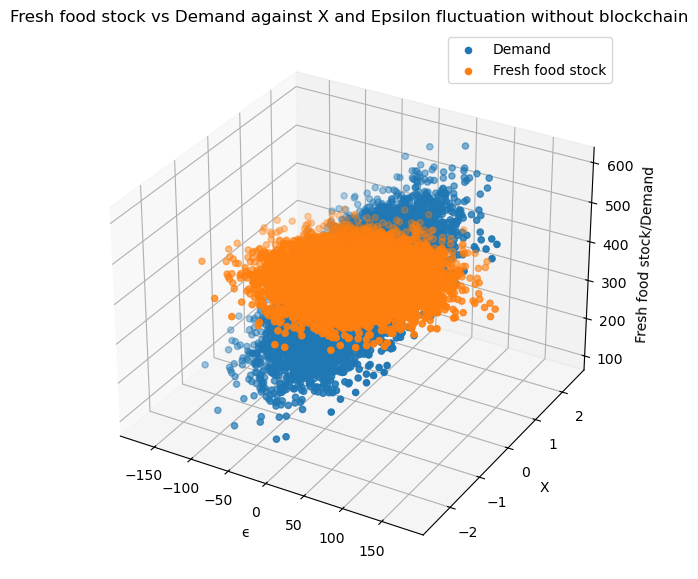

In [18]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_1_NLP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation without blockchain")
plot.show()

#### Epsilon and X prediction

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


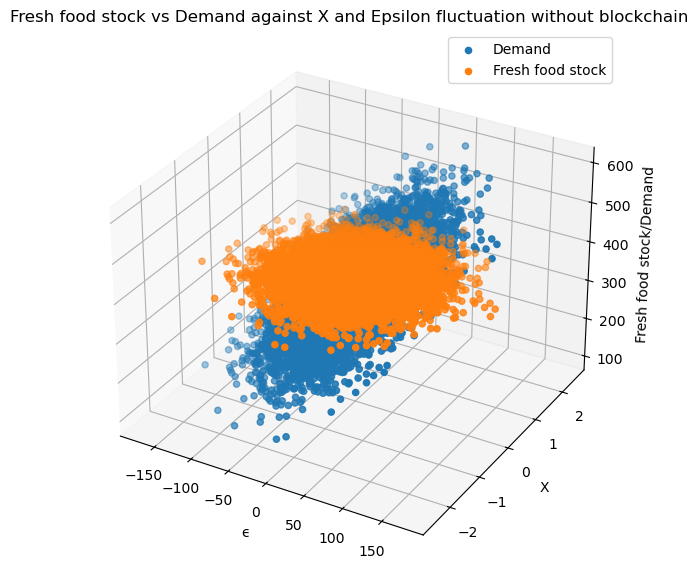

In [19]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_2_NLP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation without blockchain")
plot.show()

### Blockchain

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


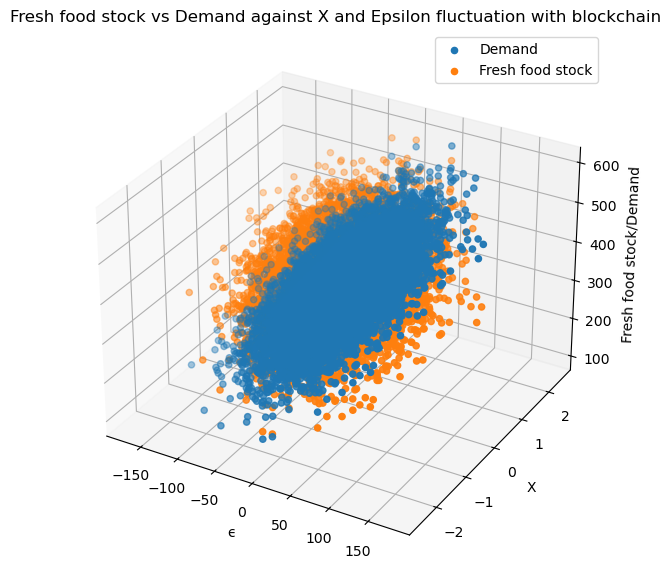

In [20]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_3_NLP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation with blockchain")
plot.show()

## Linear programming

### Traditional

#### Stock prediction

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


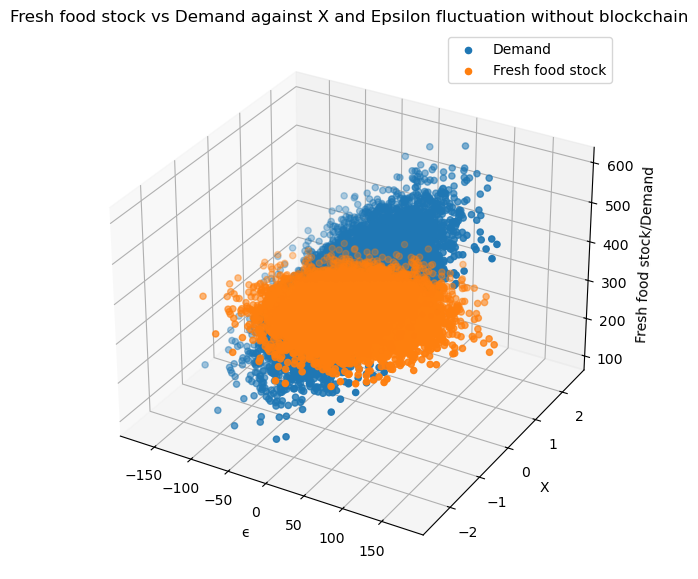

In [21]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_1_LP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation without blockchain")
plot.show()

#### X and Epsilon prediction 

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


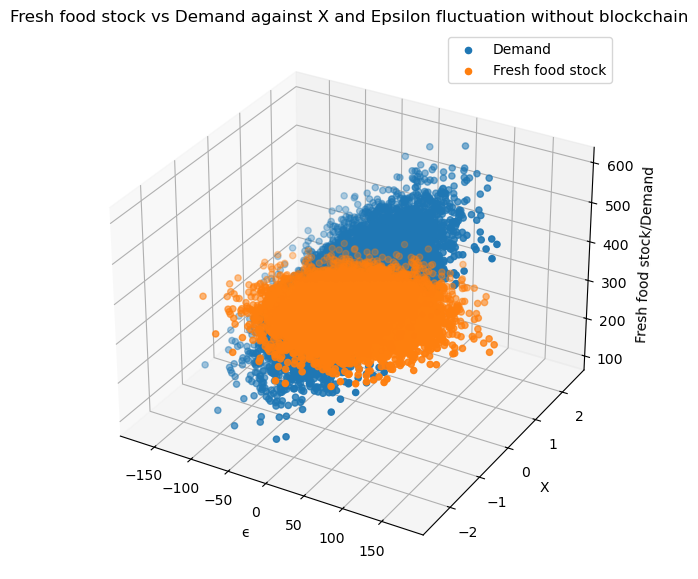

In [22]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_2_LP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation without blockchain")
plot.show()

### Blockchain

<class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>


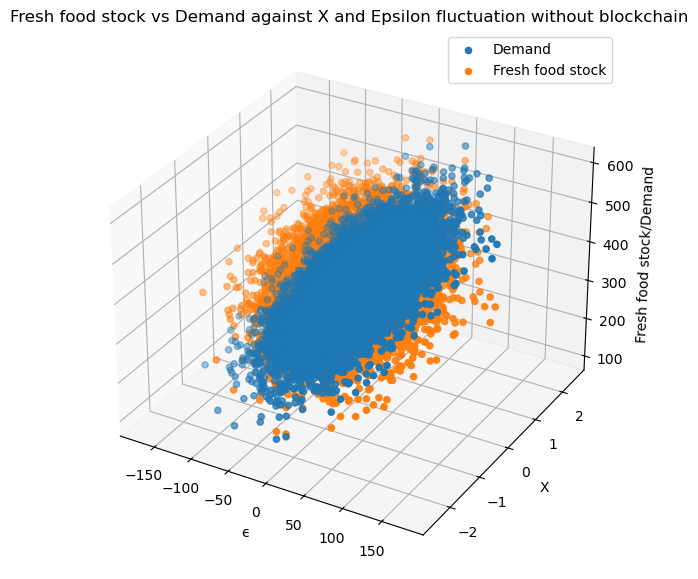

In [23]:
plot.figure(figsize=(8, 7))
axes = plot.axes(projection="3d")
print(type(axes))
# Plot Demand
axes.scatter3D(Epsilon_simulation, X_simulation, Actual_demand, label="Demand")

# Plot Fresh food stock
axes.scatter3D(Epsilon_simulation, X_simulation, Stock_3_LP, label="Fresh food stock")

axes.set_xlabel("ϵ")
axes.set_ylabel("X")
axes.set_zlabel("Fresh food stock/Demand")
axes.legend()
#axes.view_init(45, 215)
axes.set_title("Fresh food stock vs Demand against X and Epsilon fluctuation without blockchain")
plot.show()